# Speech Emotion Recognition 

### Classification for both gender on 5 emotion {Sad, Happy, Fearful, Calm, Angry}

In [59]:
## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

In [2]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir('datasets/Audio_Speech_Actors_01-24/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [4]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('datasets/Audio_Speech_Actors_01-24/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'datasets/Audio_Speech_Actors_01-24/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [5]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,1,0,8
1,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,0,0,8
2,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,0,5
3,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,1,6
4,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,1,6


In [10]:
filename = data_df.path[1031]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

datasets/Audio_Speech_Actors_01-24/Actor_18/03-01-07-02-01-01-18.wav


(22050, array([ 1.3945042e-07, -1.6381924e-07,  1.8662318e-07, ...,
        -6.8608536e-08,  5.3513180e-08,  0.0000000e+00], dtype=float32))

In [7]:
len(samples), sample_rate

(77253, 22050)

In [11]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [12]:
sample_rate/ len(samples)

0.20958083832335328

Text(0.5, 0, 'Seconds')

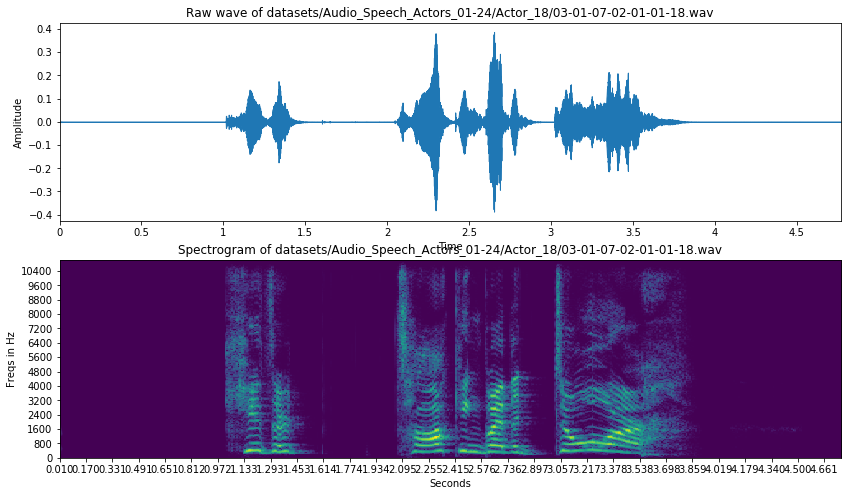

In [13]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [14]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [15]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-0.00207289,  0.00233663,  0.00387137, ..., -0.00112796,
         0.00172425,  0.00376705], dtype=float32), array([22528, 82432]))

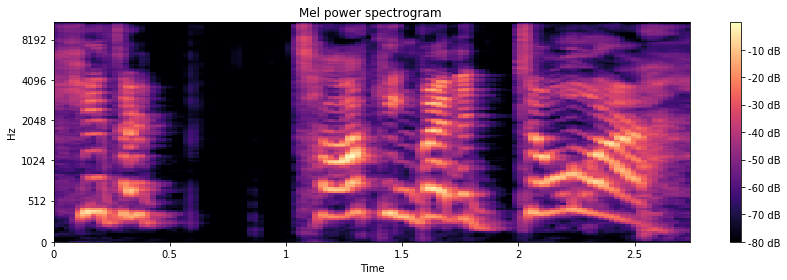

In [16]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

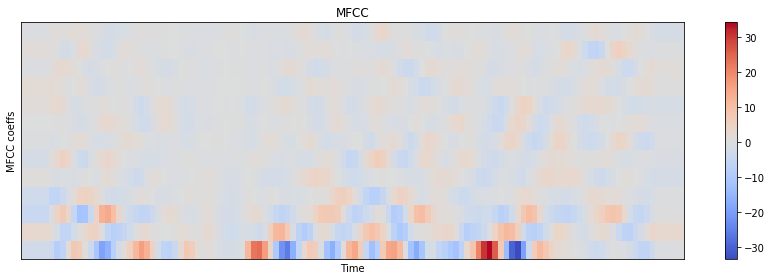

In [17]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [18]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [19]:

# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [20]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [22]:
# 5 class: angry, calm, sad, happy & fearful
label_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [23]:
data_df['label'] = label_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,1,0,8,male_none
1,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,0,0,8,male_none
2,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,0,5,male_angry
3,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,1,6,male_fearful
4,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,1,6,male_fearful


In [24]:

print (data_df.label.value_counts().keys())

Index(['male_none', 'female_none', 'male_angry', 'male_calm', 'male_fearful',
       'male_happy', 'female_calm', 'female_fearful', 'female_angry',
       'female_happy', 'male_sad', 'female_sad'],
      dtype='object')


In [25]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

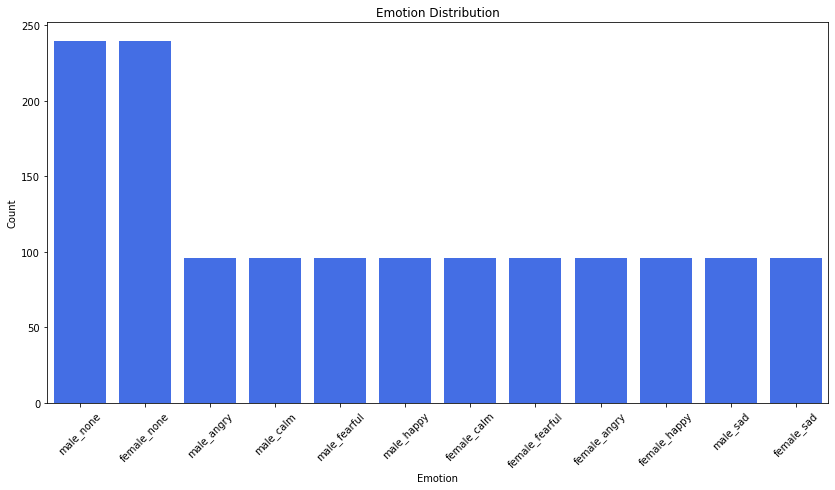

In [26]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [32]:
#angry, calm, sad, happy & fearful
data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "male_neutral"]

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp2, tmp3, tmp4],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

800


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,0,5,male_angry
1,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,1,6,male_fearful
2,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,1,6,male_fearful
3,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,0,5,male_angry
4,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,0,1,4,male_sad


In [33]:
data2_df.label.unique()

array(['male_angry', 'male_fearful', 'male_sad', 'male_happy',
       'male_calm', 'female_fearful', 'female_angry', 'female_sad',
       'female_happy', 'female_calm'], dtype=object)

In [34]:
print (len(data3_df))
data3_df.head()

160


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,0,0,1,6,male_fearful
1,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,0,0,0,5,male_angry
2,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,1,1,0,5,male_angry
3,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,1,1,1,6,male_fearful
4,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,0,1,1,4,male_sad


In [36]:

data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 800/800 [02:12<00:00,  6.03it/s]


In [37]:
data.head()

,feature
0,"[-55.663086, -56.170334, -56.157845, -54.66347..."
1,"[-63.523525, -63.523525, -63.523525, -63.52352..."
2,"[-43.19739, -44.238605, -43.996212, -44.13236,..."
3,"[-42.991745, -42.991745, -42.845966, -42.26785..."
4,"[-67.73615, -67.778015, -66.74614, -65.95788, ..."


In [38]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [39]:
newdf = pd.concat([df3,labels], axis=1)

In [40]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

800

In [41]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,380,381,382,383,384,385,386,387,388,label
0,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_angry
1,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_fearful
2,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_fearful
3,-42.991745,-42.991745,-42.845966,-42.267849,-40.690147,-40.163383,-40.072178,-42.603901,-41.733139,-41.410767,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_angry
4,-67.736153,-67.778015,-66.746140,-65.957878,-67.736153,-67.736153,-67.736153,-67.258682,-67.736153,-67.736153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_sad
5,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_sad
6,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,-57.414993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_happy
7,-60.369045,-60.083717,-60.978924,-60.952457,-60.982483,-60.983948,-60.981255,-60.981255,-60.981255,-60.249615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_happy
8,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_calm
9,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_calm


In [42]:
rnewdf.isnull().sum().sum()

91021

In [43]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,380,381,382,383,384,385,386,387,388,label
0,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_angry
1,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful
2,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful
3,-42.991745,-42.991745,-42.845966,-42.267849,-40.690147,-40.163383,-40.072178,-42.603901,-41.733139,-41.410767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_angry
4,-67.736153,-67.778015,-66.746140,-65.957878,-67.736153,-67.736153,-67.736153,-67.258682,-67.736153,-67.736153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_sad


In [44]:
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

In [45]:
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

In [47]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 800/800 [02:28<00:00,  5.39it/s]


In [48]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 800/800 [10:07<00:00,  1.32it/s]


In [49]:
len(syn_data1), len(syn_data2)

(800, 800)

In [50]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [51]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

800

In [52]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,380,381,382,383,384,385,386,387,388,label
0,-55.349625,-56.141579,-55.922817,-54.271843,-54.992165,-56.157162,-56.157162,-56.157162,-56.157162,-56.157162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_angry
1,-47.212196,-47.724052,-48.830021,-50.298592,-50.567924,-49.487221,-51.100227,-48.898872,-49.733883,-50.555443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful
2,-41.102810,-39.827194,-40.003113,-41.236488,-41.994228,-41.995075,-42.378868,-42.831184,-42.559441,-42.444595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful
3,-42.520378,-42.689030,-41.429268,-40.351627,-38.800228,-39.270309,-39.332661,-41.112667,-39.465164,-39.032665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_angry
4,-65.377243,-66.356071,-64.684090,-63.768982,-64.173531,-63.564659,-64.323273,-65.245537,-66.580147,-66.220589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_sad


In [53]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

800

In [54]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,380,381,382,383,384,385,386,387,388,label
0,-57.131035,-58.657814,-57.878304,-57.049129,-58.870224,-58.968811,-58.968811,-58.968811,-58.968811,-58.968811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_angry
1,-66.260796,-66.322617,-66.322617,-66.322617,-66.322617,-65.790154,-65.411652,-66.055557,-66.322617,-66.322617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful
2,-43.465866,-45.209713,-45.719063,-45.704079,-46.191288,-46.201431,-45.917221,-46.005188,-46.242558,-45.967163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful
3,-44.290932,-44.654907,-44.791855,-45.332928,-43.744686,-44.047119,-43.512634,-43.036587,-43.884903,-43.746010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_angry
4,-69.769279,-69.857529,-69.526558,-69.456024,-69.548233,-69.735641,-69.735641,-69.735641,-69.735641,-69.735641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_sad


In [55]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,380,381,382,383,384,385,386,387,388,label
0,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_angry
1,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful
2,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful
3,-42.991745,-42.991745,-42.845966,-42.267849,-40.690147,-40.163383,-40.072178,-42.603901,-41.733139,-41.410767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_angry
4,-67.736153,-67.778015,-66.746140,-65.957878,-67.736153,-67.736153,-67.736153,-67.258682,-67.736153,-67.736153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_sad


In [60]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [61]:
y_train.value_counts()

male_angry        192
male_calm         192
male_fearful      192
male_happy        192
female_calm       192
female_fearful    192
female_angry      192
female_happy      192
male_sad          192
female_sad        192
Name: label, dtype: int64

In [62]:
y_test.value_counts()

female_angry      48
female_calm       48
female_fearful    48
female_happy      48
male_happy        48
male_angry        48
male_calm         48
male_fearful      48
male_sad          48
female_sad        48
Name: label, dtype: int64

In [63]:
X_train.isna().sum().sum()

0

In [64]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [65]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [66]:
X_train.shape

(1920, 389)

In [67]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [68]:

# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [69]:

# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [70]:
# Plotting Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 389, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 389, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 389, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 389, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 389, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 389, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 256)          

In [71]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [72]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('model/5class_1.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Train on 1920 samples, validate on 480 samples
Epoch 1/700
1920/1920 [==============================] - 28s 14ms/step - loss: 2.3488 - accuracy: 0.1536 - val_loss: 2.2962 - val_accuracy: 0.1042
Epoch 2/700
1920/1920 [==============================] - 29s 15ms/step - loss: 2.1708 - accuracy: 0.2120 - val_loss: 2.2333 - val_accuracy: 0.1771
Epoch 3/700
1920/1920 [==============================] - 35s 18ms/step - loss: 2.0931 - accuracy: 0.2422 - val_loss: 2.1599 - val_accuracy: 0.2417
Epoch 4/700
1920/1920 [==============================] - 34s 17ms/step - loss: 2.0354 - accuracy: 0.2797 - val_loss: 2.1087 - val_accuracy: 0.2562
Epoch 5/700
1920/1920 [==============================] - 29s 15ms/step - loss: 1.9865 - accuracy: 0.3068 - val_loss: 2.0843 - val_accuracy: 0.3063
Epoch 6/700
1920/1920 [==============================] - 30s 16ms/step - loss: 1.9540 - accuracy: 0.3260 - val_loss: 2.0616 - val_accuracy: 0.3229
Epoch 7/700
1920/1920 [==============================] - 31s 16ms/step 

1920/1920 [==============================] - 26s 13ms/step - loss: 0.8391 - accuracy: 0.7328 - val_loss: 1.2108 - val_accuracy: 0.6292
Epoch 112/700
1920/1920 [==============================] - 26s 14ms/step - loss: 0.8329 - accuracy: 0.7344 - val_loss: 1.2414 - val_accuracy: 0.5938
Epoch 113/700
1920/1920 [==============================] - 26s 13ms/step - loss: 0.8197 - accuracy: 0.7490 - val_loss: 1.2179 - val_accuracy: 0.6354
Epoch 114/700
1920/1920 [==============================] - 26s 13ms/step - loss: 0.8226 - accuracy: 0.7380 - val_loss: 1.3209 - val_accuracy: 0.5417
Epoch 115/700
1920/1920 [==============================] - 25s 13ms/step - loss: 0.8217 - accuracy: 0.7469 - val_loss: 1.3415 - val_accuracy: 0.5562
Epoch 116/700
1920/1920 [==============================] - 23s 12ms/step - loss: 0.7999 - accuracy: 0.7474 - val_loss: 1.1552 - val_accuracy: 0.6646
Epoch 117/700
1920/1920 [==============================] - 22s 11ms/step - loss: 0.7946 - accuracy: 0.7609 - val_loss: 1

1920/1920 [==============================] - 20s 11ms/step - loss: 0.5657 - accuracy: 0.8453 - val_loss: 0.9760 - val_accuracy: 0.7042
Epoch 167/700
1920/1920 [==============================] - 20s 11ms/step - loss: 0.5679 - accuracy: 0.8365 - val_loss: 1.0497 - val_accuracy: 0.6479
Epoch 168/700
1920/1920 [==============================] - 21s 11ms/step - loss: 0.5534 - accuracy: 0.8521 - val_loss: 0.9829 - val_accuracy: 0.7063
Epoch 169/700
1920/1920 [==============================] - 21s 11ms/step - loss: 0.5583 - accuracy: 0.8505 - val_loss: 0.9641 - val_accuracy: 0.7375
Epoch 170/700
1920/1920 [==============================] - 21s 11ms/step - loss: 0.5518 - accuracy: 0.8505 - val_loss: 1.0434 - val_accuracy: 0.6896
Epoch 171/700
1920/1920 [==============================] - 22s 11ms/step - loss: 0.5448 - accuracy: 0.8568 - val_loss: 0.9698 - val_accuracy: 0.7292
Epoch 172/700
1920/1920 [==============================] - 20s 11ms/step - loss: 0.5544 - accuracy: 0.8422 - val_loss: 0

1920/1920 [==============================] - 22s 11ms/step - loss: 0.3677 - accuracy: 0.9130 - val_loss: 0.9439 - val_accuracy: 0.7188
Epoch 222/700
1920/1920 [==============================] - 21s 11ms/step - loss: 0.3576 - accuracy: 0.9260 - val_loss: 0.7767 - val_accuracy: 0.8167
Epoch 223/700
1920/1920 [==============================] - 21s 11ms/step - loss: 0.3510 - accuracy: 0.9240 - val_loss: 0.8200 - val_accuracy: 0.8062
Epoch 224/700
1920/1920 [==============================] - 21s 11ms/step - loss: 0.3601 - accuracy: 0.9208 - val_loss: 0.8355 - val_accuracy: 0.7729
Epoch 225/700
1920/1920 [==============================] - 21s 11ms/step - loss: 0.3567 - accuracy: 0.9193 - val_loss: 1.0211 - val_accuracy: 0.6604
Epoch 226/700
1920/1920 [==============================] - 21s 11ms/step - loss: 0.3603 - accuracy: 0.9167 - val_loss: 0.7388 - val_accuracy: 0.8125
Epoch 227/700
1920/1920 [==============================] - 21s 11ms/step - loss: 0.3584 - accuracy: 0.9245 - val_loss: 0

1920/1920 [==============================] - 27s 14ms/step - loss: 0.2412 - accuracy: 0.9557 - val_loss: 0.6909 - val_accuracy: 0.8250
Epoch 277/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.2403 - accuracy: 0.9609 - val_loss: 0.6252 - val_accuracy: 0.8521
Epoch 278/700
1920/1920 [==============================] - 26s 14ms/step - loss: 0.2371 - accuracy: 0.9609 - val_loss: 0.6881 - val_accuracy: 0.8229
Epoch 279/700
1920/1920 [==============================] - 31s 16ms/step - loss: 0.2387 - accuracy: 0.9526 - val_loss: 0.7042 - val_accuracy: 0.8083
Epoch 280/700
1920/1920 [==============================] - 29s 15ms/step - loss: 0.2420 - accuracy: 0.9510 - val_loss: 0.6494 - val_accuracy: 0.8500
Epoch 281/700
1920/1920 [==============================] - 26s 14ms/step - loss: 0.2430 - accuracy: 0.9510 - val_loss: 0.6419 - val_accuracy: 0.8500
Epoch 282/700
1920/1920 [==============================] - 28s 14ms/step - loss: 0.2246 - accuracy: 0.9625 - val_loss: 0

1920/1920 [==============================] - 31s 16ms/step - loss: 0.1608 - accuracy: 0.9781 - val_loss: 0.5241 - val_accuracy: 0.8729
Epoch 332/700
1920/1920 [==============================] - 32s 16ms/step - loss: 0.1641 - accuracy: 0.9792 - val_loss: 0.5456 - val_accuracy: 0.8729
Epoch 333/700
1920/1920 [==============================] - 30s 16ms/step - loss: 0.1696 - accuracy: 0.9771 - val_loss: 0.6501 - val_accuracy: 0.8083
Epoch 334/700
1920/1920 [==============================] - 28s 15ms/step - loss: 0.1605 - accuracy: 0.9771 - val_loss: 0.6751 - val_accuracy: 0.8062
Epoch 335/700
1920/1920 [==============================] - 30s 16ms/step - loss: 0.1467 - accuracy: 0.9818 - val_loss: 0.6331 - val_accuracy: 0.8229
Epoch 336/700
1920/1920 [==============================] - 32s 17ms/step - loss: 0.1557 - accuracy: 0.9786 - val_loss: 0.5542 - val_accuracy: 0.8604
Epoch 337/700
1920/1920 [==============================] - 30s 16ms/step - loss: 0.1498 - accuracy: 0.9802 - val_loss: 0

1920/1920 [==============================] - 32s 17ms/step - loss: 0.1156 - accuracy: 0.9859 - val_loss: 0.5721 - val_accuracy: 0.8479
Epoch 387/700
1920/1920 [==============================] - 34s 18ms/step - loss: 0.1169 - accuracy: 0.9880 - val_loss: 0.4768 - val_accuracy: 0.8958
Epoch 388/700
1920/1920 [==============================] - 32s 17ms/step - loss: 0.1236 - accuracy: 0.9833 - val_loss: 0.5179 - val_accuracy: 0.8667
Epoch 389/700
1920/1920 [==============================] - 35s 18ms/step - loss: 0.1155 - accuracy: 0.9885 - val_loss: 0.4904 - val_accuracy: 0.8792
Epoch 390/700
1920/1920 [==============================] - 32s 17ms/step - loss: 0.1128 - accuracy: 0.9917 - val_loss: 0.4910 - val_accuracy: 0.8958
Epoch 391/700
1920/1920 [==============================] - 37s 19ms/step - loss: 0.1252 - accuracy: 0.9849 - val_loss: 0.5215 - val_accuracy: 0.8625
Epoch 392/700
1920/1920 [==============================] - 30s 16ms/step - loss: 0.1090 - accuracy: 0.9906 - val_loss: 0

Epoch 496/700
1920/1920 [==============================] - 29s 15ms/step - loss: 0.0678 - accuracy: 0.9964 - val_loss: 0.4067 - val_accuracy: 0.9042
Epoch 497/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.0687 - accuracy: 0.9937 - val_loss: 0.4004 - val_accuracy: 0.9021
Epoch 498/700
1920/1920 [==============================] - 28s 15ms/step - loss: 0.0643 - accuracy: 0.9958 - val_loss: 0.4193 - val_accuracy: 0.8917
Epoch 499/700
1920/1920 [==============================] - 29s 15ms/step - loss: 0.0612 - accuracy: 0.9964 - val_loss: 0.3703 - val_accuracy: 0.9146
Epoch 500/700
1920/1920 [==============================] - 30s 16ms/step - loss: 0.0673 - accuracy: 0.9943 - val_loss: 0.3852 - val_accuracy: 0.9187
Epoch 501/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.0656 - accuracy: 0.9943 - val_loss: 0.4688 - val_accuracy: 0.8708
Epoch 502/700
1920/1920 [==============================] - 28s 14ms/step - loss: 0.0641 - accuracy: 0.9948

Epoch 551/700
1920/1920 [==============================] - 28s 15ms/step - loss: 0.0517 - accuracy: 0.9979 - val_loss: 0.3707 - val_accuracy: 0.9146
Epoch 552/700
1920/1920 [==============================] - 28s 14ms/step - loss: 0.0542 - accuracy: 0.9979 - val_loss: 0.3723 - val_accuracy: 0.9146
Epoch 553/700
1920/1920 [==============================] - 28s 15ms/step - loss: 0.0507 - accuracy: 0.9958 - val_loss: 0.3631 - val_accuracy: 0.9062
Epoch 554/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.0521 - accuracy: 0.9958 - val_loss: 0.3642 - val_accuracy: 0.9146
Epoch 555/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.0552 - accuracy: 0.9969 - val_loss: 0.4259 - val_accuracy: 0.8938
Epoch 556/700
1920/1920 [==============================] - 29s 15ms/step - loss: 0.0530 - accuracy: 0.9958 - val_loss: 0.4042 - val_accuracy: 0.9000
Epoch 557/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.0475 - accuracy: 0.9979

Epoch 606/700
1920/1920 [==============================] - 26s 13ms/step - loss: 0.0470 - accuracy: 0.9958 - val_loss: 0.3485 - val_accuracy: 0.9146
Epoch 607/700
1920/1920 [==============================] - 28s 15ms/step - loss: 0.0448 - accuracy: 0.9974 - val_loss: 0.3380 - val_accuracy: 0.9208
Epoch 608/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.0425 - accuracy: 0.9969 - val_loss: 0.3649 - val_accuracy: 0.9042
Epoch 609/700
1920/1920 [==============================] - 26s 13ms/step - loss: 0.0434 - accuracy: 0.9964 - val_loss: 0.3654 - val_accuracy: 0.9083
Epoch 610/700
1920/1920 [==============================] - 25s 13ms/step - loss: 0.0407 - accuracy: 0.9979 - val_loss: 0.3700 - val_accuracy: 0.9000
Epoch 611/700
1920/1920 [==============================] - 26s 13ms/step - loss: 0.0421 - accuracy: 0.9984 - val_loss: 0.3640 - val_accuracy: 0.9104
Epoch 612/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.0487 - accuracy: 0.9948

Epoch 661/700
1920/1920 [==============================] - 28s 14ms/step - loss: 0.0351 - accuracy: 0.9984 - val_loss: 0.3261 - val_accuracy: 0.9208
Epoch 662/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.0400 - accuracy: 0.9990 - val_loss: 0.3430 - val_accuracy: 0.9208
Epoch 663/700
1920/1920 [==============================] - 29s 15ms/step - loss: 0.0377 - accuracy: 0.9979 - val_loss: 0.4461 - val_accuracy: 0.8854
Epoch 664/700
1920/1920 [==============================] - 26s 14ms/step - loss: 0.0413 - accuracy: 0.9964 - val_loss: 0.3246 - val_accuracy: 0.9167
Epoch 665/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.0363 - accuracy: 0.9979 - val_loss: 0.3330 - val_accuracy: 0.9104
Epoch 666/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.0391 - accuracy: 0.9984 - val_loss: 0.3485 - val_accuracy: 0.9042
Epoch 667/700
1920/1920 [==============================] - 27s 14ms/step - loss: 0.0391 - accuracy: 0.9979

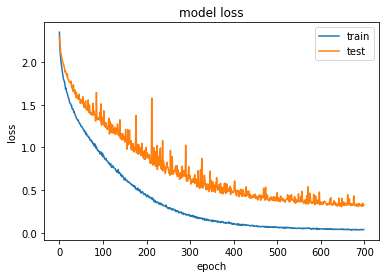

In [73]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [74]:
# Saving the model.json

import json
model_json = model.to_json()
with open("En_5Class.json", "w") as json_file:
    json_file.write(model_json)

In [75]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('En_5Class.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/5class_1.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 93.12%


In [76]:
print('Train loss', cnnhistory.history['loss'][-1])
print('Test loss', cnnhistory.history['val_loss'][-1])

Train Accuracy 0.03815428519931932
Test Accuracy 0.31761704658468565


In [77]:
cnnhistory.history['accuracy'][-1]

0.9973958

In [78]:
cnnhistory.history['val_accuracy'][-1]

0.9229166507720947